# Counter-AI

## Objective
The objective of this project is to build a classifier that can identify if an answer to a StackOverflow question was generated by a human or GPT language model.

## Data
The data for this project was fetched from StackExchange and OpenAI public APIs

# Data Preparation and Analysis

In [1]:
import pandas as pd
import numpy as np
from util.preprocess_util import label, remove_duplicates, tokenize, strip_whites

[nltk_data] Downloading package punkt to /home/iliav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
labeled_data = pd.read_json("./data/balanced_data.jsonl", lines=True)
labeled_data.sample()

,question_id,answer,target,question
2478,20363719,Here's how you can do it in Java 8 without Gua...,1,"How do you trigger a block after a delay, like..."


## Cleanup

We see, that ai answers tend to start with newline, so let's strip whitespaces from both the whole `answer` column

In [3]:
strip_whites(labeled_data)
labeled_data[:4]

,question_id,answer,target,question
0,11227809,An answer for quick and simple understanding (...,0,Why is processing a sorted array faster than p...
1,292357,Fetch\ngit fetch really only downloads new dat...,0,How do I undo the most recent local commits in...
2,477816,The most common MIME type is application/json....,0,How do I delete a Git branch locally and remot...
3,5767325,"let removeAnElement = (arr, element)=>{\n l...",0,What is the difference between 'git pull' and ...


## Tokenizing questions and answers
To handle the text data it's convenient to tokenize it, i.e. split into separate words (tokens). We'll also immediately stem the tokens, so that different forms of the same word become a single token

In [4]:
tokenize(labeled_data)
labeled_data[['tokenized_answer', 'tokenized_question']]

,tokenized_answer,tokenized_question
0,"[an, answer, for, quick, and, simpl, understan...","[whi, is, process, a, sort, array, faster, tha..."
1,"[fetch, git, fetch, realli, onli, download, ne...","[how, do, i, undo, the, most, recent, local, c..."
2,"[the, most, common, mime, type, is, applicatio...","[how, do, i, delet, a, git, branch, local, and..."
3,"[let, removeanel, =, (arr,, element)=>{, let, ...","[what, is, the, differ, between, git, pull, an..."
4,"[i, search, all, page, of, answers,, and, none...","[what, doe, the, ""yield"", keyword, do?, can, i..."
...,...,...
2889,"[to, delet, a, git, repositori, that, was, cre...","[how, to, chang, indent, in, visual, studio, c..."
2890,"[you, are, not, do, anyth, wrong., the, fast-f...","[how, to, specifi, a, port, to, run, a, create..."
2891,"[the, differ, between, the, three, is:, simpl,...","[what, the, postgresql, datatyp, equival, to, ..."
2892,"[googl, use, javascript, to, captur, screensho...","[doe, python, have, an, order, set?, googl, ""r..."


Later we'll need also stemmed answer as a string

In [5]:
labeled_data['stemmed_answer']

0       an answer for quick and simpl understand (read...
1       fetch git fetch realli onli download new data ...
2       the most common mime type is application/json....
3       let removeanel = (arr, element)=>{ let findind...
4       i search all page of answers, and none mention...
                              ...                        
2889    to delet a git repositori that was creat with ...
2890    you are not do anyth wrong. the fast-forward m...
2891    the differ between the three is: simpl name: g...
2892    googl use javascript to captur screenshot in t...
2893    the issu is that the server you are tri to fet...
Name: stemmed_answer, Length: 2894, dtype: object

## Feature Engineering
I have several hypotheses about the behaviour of GPT:
1. It tends to repeat parts of the question in its answer
2. Its own vocabulary is smaller and less variate comparing to average human's
3. The size of the answers is less variate than that of humans'

Keeping these in mind I'll create several numerical features and later try to train a regression model on them.

### Helpers

In [6]:
from util.preprocess_util import add_stealing, add_vocabulary, add_creativity, add_answer_length, add_sentence_length

In [7]:
from util.plot_util import comparation_hist

### Feature: Creativity
I'm introducing the term creativity to describe how many original words are used in the answer. Hence the feature:
* `creativity` - number of all unique words in the answer that are not present in the question, divided by the size of the answer

In [8]:
add_creativity(labeled_data)

In [9]:
labeled_data.creativity.mean()

0.5107463936441272

In [10]:
labeled_data[labeled_data.target==0].creativity.mean(), labeled_data[labeled_data.target==1].creativity.mean()


(0.5814716015368749, 0.4400211857513793)

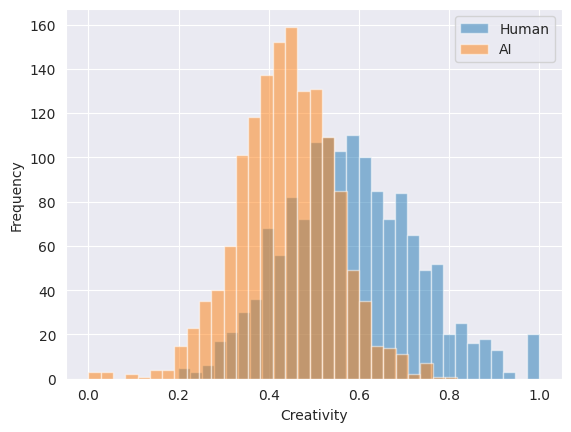

In [11]:
comparation_hist(labeled_data, 'creativity', 'Creativity')

There is obviously a difference in creativity between humans and AI

### Feature: Vocabulary Size
Assuming that number of unique words may be different in human and AI answers, I'm introducing two more features:
* `n_unique_words` - number of unique words in the answer
* `vocabulary_size` - `unique_words` divided by the size of the tokenized answer

In [12]:
add_vocabulary(labeled_data)

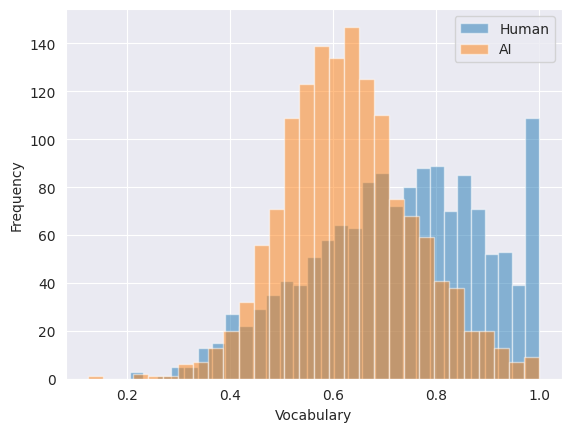

In [13]:
comparation_hist(labeled_data, 'vocabulary_size', 'Vocabulary')

### Feature: Stealing
Opposite to creativity, stealing shows how many words sequences were 'stolen' from the question and taken into the answer. I'm breaking questions and answers into n-grams (word sequences of length n) and then find the common ngrams. Then I create two features:

* `stealing_strength` - maximum length (number of words) of a stolen ngram
* `stealing_frequency` - total number of stolen ngrams divided by number of unique words

In [14]:
%%time
add_stealing(labeled_data)

CPU times: user 3.52 s, sys: 6.36 ms, total: 3.53 s
Wall time: 3.53 s


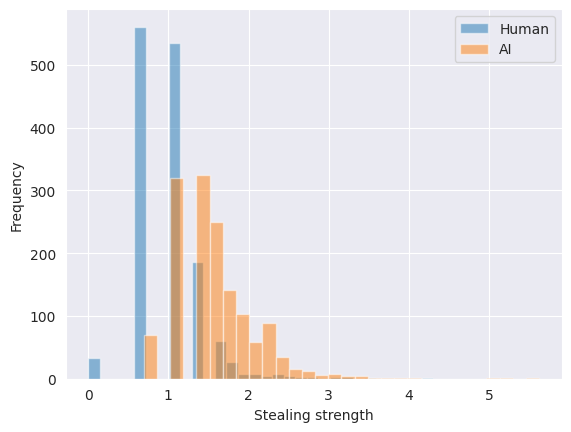

In [15]:
comparation_hist(labeled_data, 'stealing_strength', 'Stealing strength')

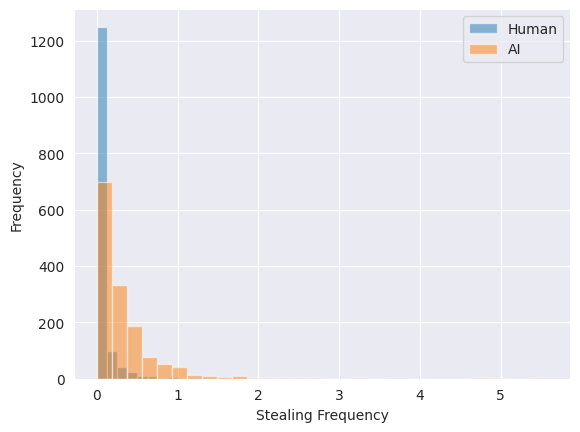

In [16]:
comparation_hist(labeled_data, 'stealing_frequency', 'Stealing Frequency')

### Feature: Answer Length
Even though I've limited maximum answer length of human- and ai- generated answers, the distribution might still be different. So another feature:
* `answer_length`

In [17]:
add_answer_length(labeled_data)

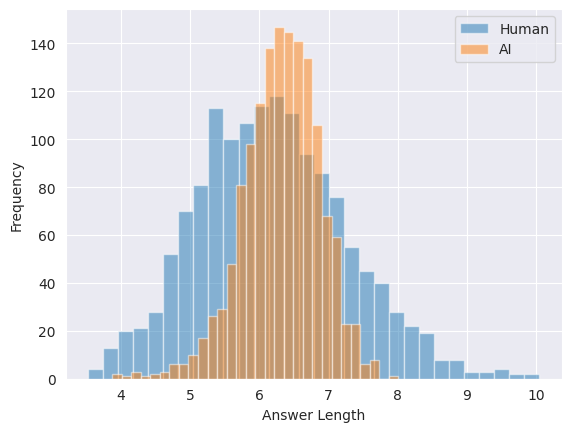

In [18]:
comparation_hist(labeled_data, 'answer_length', 'Answer Length')

### Feature: Sentence length
Here I'm adding two more metrics related to sentence length in answer calculated as number of tokens.
* `sentence_length_mean` - mean length of sentences (log1p applied)
* `sentence_length_std` - standard deviation length of sentences (log1p applied)

In [19]:
add_sentence_length(labeled_data)

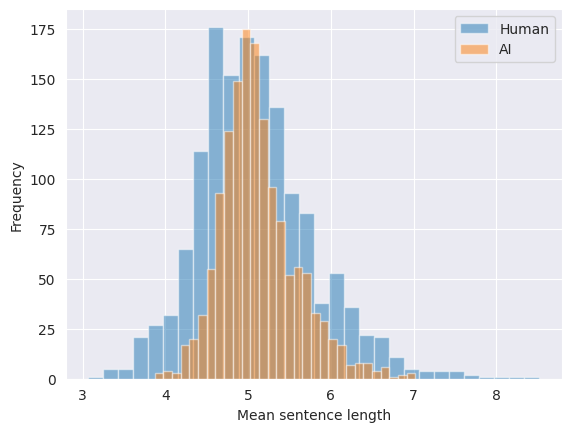

In [20]:
comparation_hist(labeled_data, 'sentence_length_mean', 'Mean sentence length')

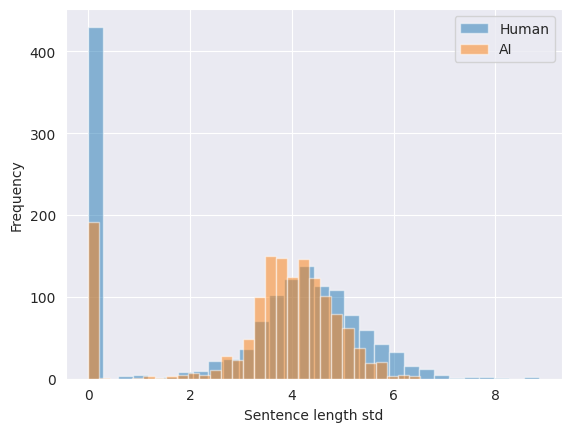

In [21]:
comparation_hist(labeled_data, 'sentence_length_std', 'Sentence length std')

### Features correlation

In [22]:
labeled_data = labeled_data.fillna(0)
all_features = ['creativity', 'stealing_strength', 'stealing_frequency', 'sentence_length_mean', 'sentence_length_std', 'answer_length', 'vocabulary_size']

<AxesSubplot: >

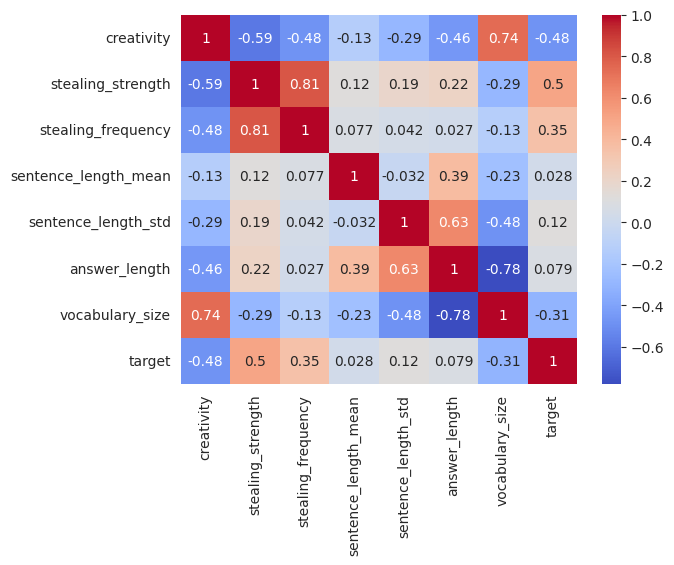

In [23]:
import seaborn as sns

sns.heatmap(labeled_data[all_features + ['target']].corr(), annot=True, cmap='coolwarm')

* All features except `sentence_length_mean` and `answer_length` show significant correlation with target

## Saving preprocessed data
Some steps like calculating stolen ngrams take too long to perform them with every training script, so I'm saving this preprocessed data for future usage in production model training

In [24]:
labeled_data.to_json("data/preprocessed.jsonl", lines=True, orient="records")

# Training models
I'm going to train several models and compare the results:
1. Logistic regression on the new features and select the best
2. Naive Bayes on vectorized answers
3. Combination of the previous two in two-layered pipeline

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from util.train_util import grid_search
from util.plot_util import plot_grid_results

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

## Data split

In [26]:
df_full_train, df_test = train_test_split(labeled_data, test_size=0.2, random_state=42)

## Logistic regression

In [27]:
lr = LogisticRegression(max_iter=500, class_weight="balanced")
features = []
scores = []
for f in all_features:
    features.append(f)
    score = cross_val_score(lr, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,creativity,0.723
1,stealing_strength,0.763
2,stealing_frequency,0.765
3,sentence_length_mean,0.773
4,sentence_length_std,0.775
5,answer_length,0.778
6,vocabulary_size,0.800


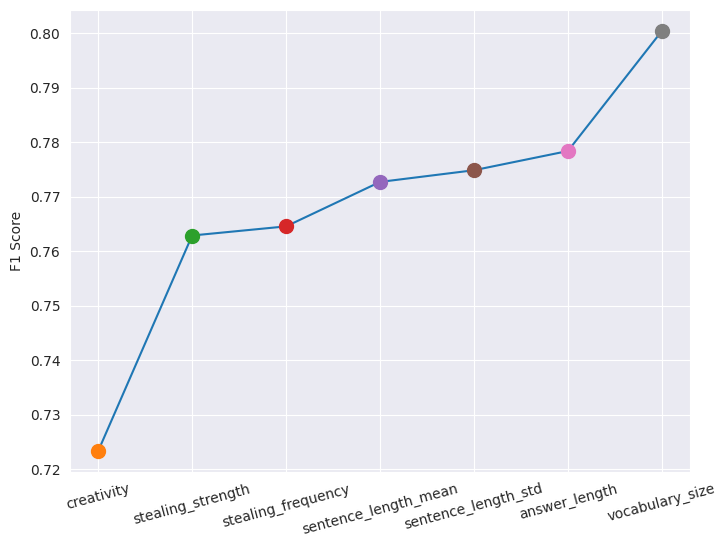

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=all_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(all_features)):
    plt.plot(all_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("features_input.png")

Conclusions:
* `stealing_frequency` and `sentence_length_std` do not add much to the performance

In [29]:
selected_features = [f for f in all_features if f not in ['sentence_length_mean']]
selected_features

['creativity',
 'stealing_strength',
 'stealing_frequency',
 'sentence_length_std',
 'answer_length',
 'vocabulary_size']

In [30]:
lr_tuning_grid = {
    'C': np.logspace(-3,2,6),
    'solver': ['lbfgs', 'liblinear', 'sag']
}
grid_search_results = grid_search(lr, lr_tuning_grid, df_full_train[selected_features], df_full_train.target)

Tuned Hyperparameters: {'C': 10.0, 'solver': 'lbfgs'}
F1 score : 0.8024910573040313


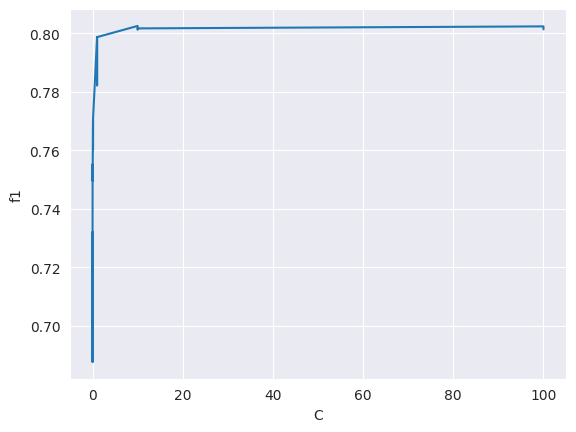

In [31]:
plot_grid_results(grid_search_results, x_var='C')

### Score on Test Data

In [32]:
lr = LogisticRegression(C=10.0, solver='sag', class_weight="balanced")
lr.fit(df_full_train[selected_features], df_full_train.target)
lr_score = round(f1_score(lr.predict(df_test[selected_features]), df_test.target), 3)
lr_score

/home/iliav/Documents/workspaces/counter-ai/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.772

## XGBoost

In [33]:
from xgboost.sklearn import XGBClassifier

scale_pos_weight = df_full_train.target.value_counts()[0] / df_full_train.target.value_counts()[1]

xgb = XGBClassifier(learning_rate = 0.3, n_estimators = 20, scale_pos_weight=scale_pos_weight)

features = []
scores = []
for f in all_features:
    features.append(f)
    score = cross_val_score(xgb, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,creativity,0.731
1,stealing_strength,0.758
2,stealing_frequency,0.769
3,sentence_length_mean,0.798
4,sentence_length_std,0.808
5,answer_length,0.830
6,vocabulary_size,0.835


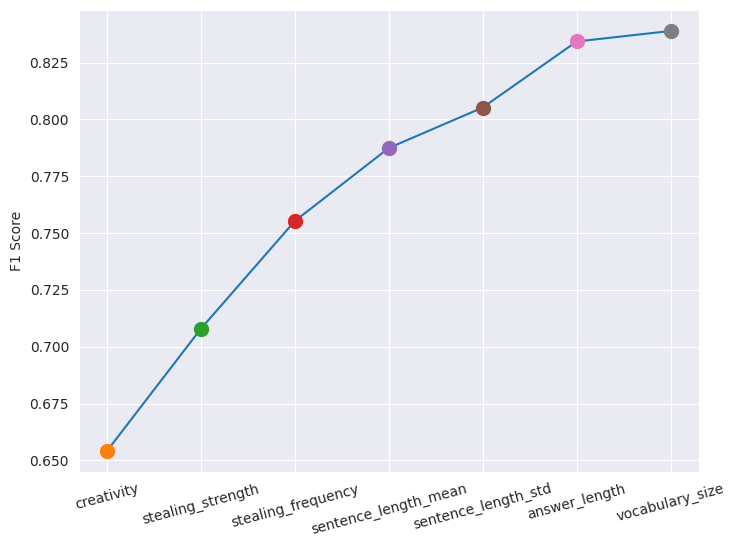

In [72]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=all_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(all_features)):
    plt.plot(all_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("xgb_features_input.png")

Conclusions:
* All features except for `stealing_frequency` do add to the final score
* XGB shows significant improvement comparing to Logistic Regression

In [35]:
%%time
xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}
F1 score : 0.8421834713019904
CPU times: user 6min 33s, sys: 1.71 s, total: 6min 35s
Wall time: 49.6 s


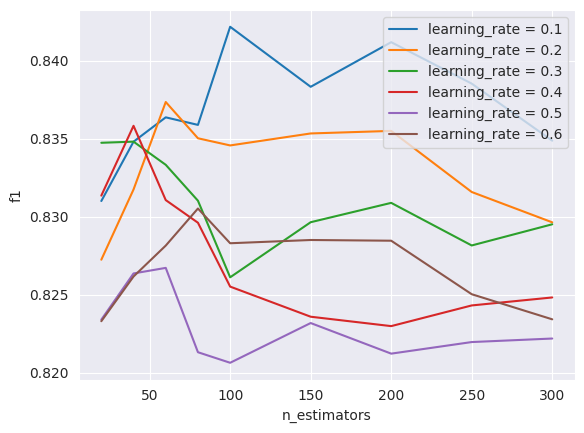

In [36]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='learning_rate')

In [37]:
%%time

xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1],
    'max_depth': [2, 3, 4, 5, 6, 7]
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250}
F1 score : 0.8467019319531726
CPU times: user 4min 56s, sys: 1.2 s, total: 4min 58s
Wall time: 37.4 s


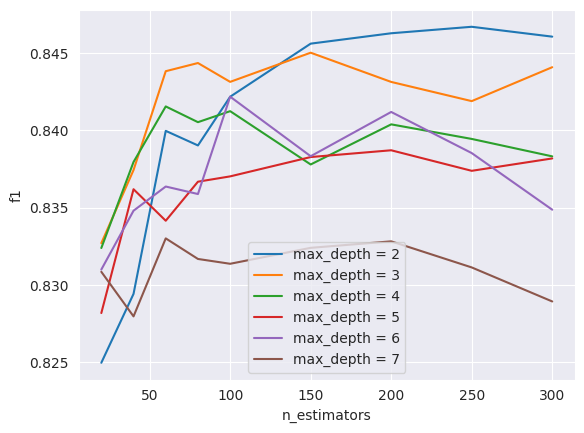

In [38]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_depth')

In [39]:
%%time

xgb_tuning_grid = {
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'learning_rate': [0.1],
    'max_depth': [4],
    'min_child_weight': [1, 2, 3, 4]
}
grid_search_results = grid_search(xgb, xgb_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 80}
F1 score : 0.8441069503300724
CPU times: user 3min 4s, sys: 636 ms, total: 3min 5s
Wall time: 23.3 s


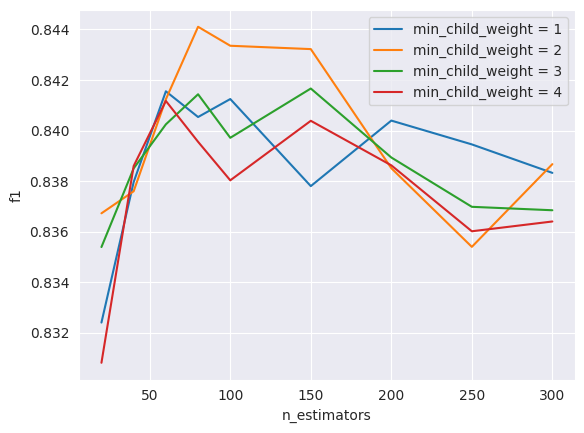

In [40]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_child_weight')

### Score on Test Data

In [41]:
xgb.set_params(**{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100})
xgb.fit(df_full_train[all_features], df_full_train.target)
xgb_score = round(f1_score(xgb.predict(df_test[all_features]), df_test.target), 3)
xgb_score

0.829

## Random Forest

In [42]:

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight="balanced")

features = []
scores = []
for f in all_features:
    features.append(f)
    score = cross_val_score(rfc, df_full_train[features], df_full_train.target, scoring='f1').mean()
    scores.append(score)
pd.DataFrame(list(zip(features, np.round(scores, 3))))

,0,1
0,creativity,0.654
1,stealing_strength,0.708
2,stealing_frequency,0.755
3,sentence_length_mean,0.787
4,sentence_length_std,0.805
5,answer_length,0.834
6,vocabulary_size,0.839


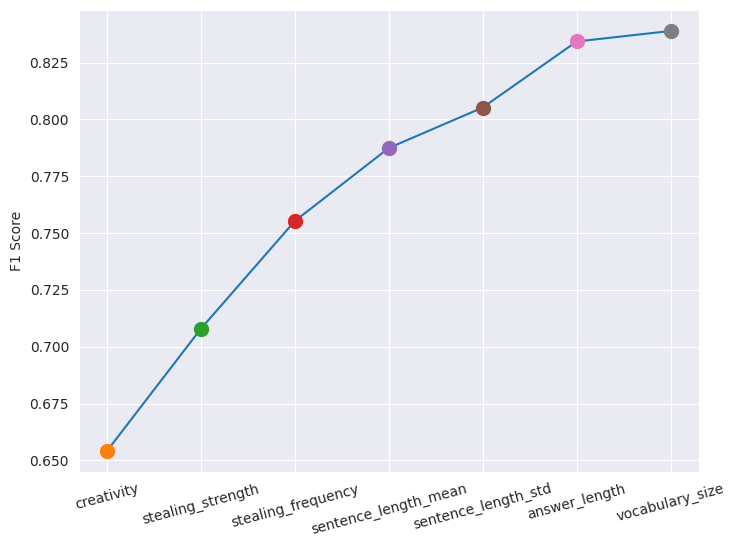

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))

sns.lineplot(x=all_features, y=scores)
plt.xticks(rotation=15)
for i in range(len(all_features)):
    plt.plot(all_features[i], scores[i], 'o', markersize=10)
plt.ylabel('F1 Score')
plt.savefig("features_input.png")

Conclusions:
* All features do add to the final score
* Random Forest shows similar results to XGBoost

In [44]:
%%time
rfc_tuning_grid = {
    'max_depth': [50, 100, 200, 300, None],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int)))
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 200, 'n_estimators': 300}
F1 score : 0.8425958636843747
CPU times: user 1min 14s, sys: 54.5 ms, total: 1min 14s
Wall time: 1min 14s


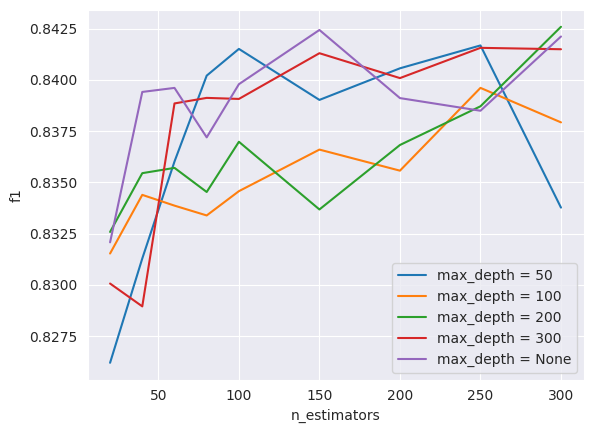

In [45]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_depth')

In [46]:
%%time

rfc_tuning_grid = {
    'max_depth': [200],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': ['sqrt', None]
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 200, 'max_features': 'sqrt', 'n_estimators': 150}
F1 score : 0.8421155595553277
CPU times: user 47.6 s, sys: 16.6 ms, total: 47.7 s
Wall time: 47.7 s


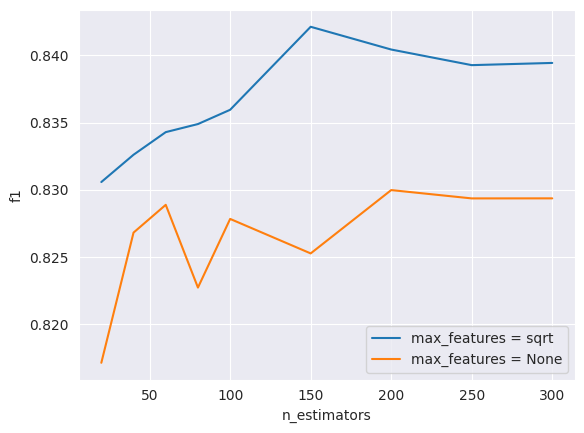

In [47]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='max_features')

In [48]:
%%time

rfc_tuning_grid = {
    'max_depth': [200],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': [None],
    'min_samples_leaf': [1, 2, 3, 4, 5],

}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 200, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 80}
F1 score : 0.8343768421455879
CPU times: user 2min 33s, sys: 61.4 ms, total: 2min 33s
Wall time: 2min 33s


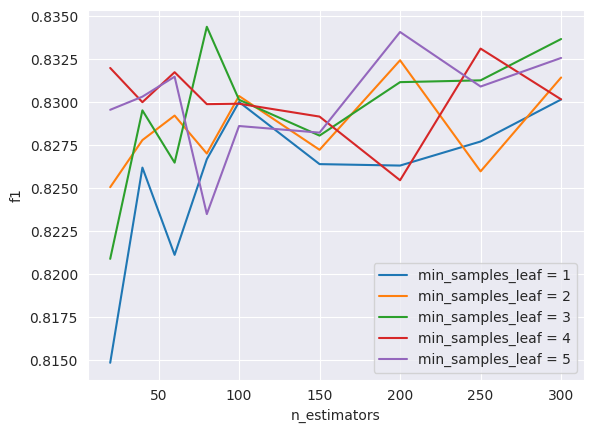

In [49]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_samples_leaf')

In [50]:
%%time

rfc_tuning_grid = {
    'max_depth': [200],
    'n_estimators': np.concatenate((np.linspace(20, 100, 5, dtype=int),
                                           np.linspace(150, 300, 4, dtype=int))),
    'max_features': [None],
    'min_samples_leaf': [3],
    'min_samples_split': [2, 10, 50, 100, 200]
}
grid_search_results = grid_search(rfc, rfc_tuning_grid, df_full_train[all_features], df_full_train.target)

Tuned Hyperparameters: {'max_depth': 200, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}
F1 score : 0.8334846453498361
CPU times: user 2min 14s, sys: 94.1 ms, total: 2min 14s
Wall time: 2min 14s


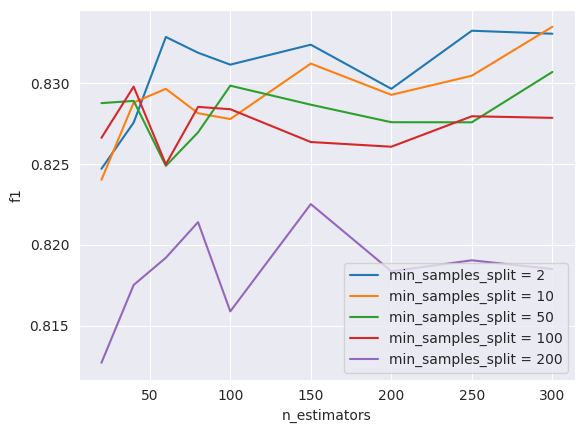

In [51]:
plot_grid_results(grid_search_results, x_var='n_estimators', legend_var='min_samples_split')

### Score on Test Data

In [52]:
rfc.set_params(**{'max_depth': 200, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 250})
rfc.fit(df_full_train[all_features], df_full_train.target)
rfc_score = round(f1_score(rfc.predict(df_test[all_features]), df_test.target), 3)
rfc_score

0.823

## Naive Bayes

In [53]:
count_vectorizer = CountVectorizer(min_df=10)
vectors = count_vectorizer.fit_transform(df_full_train.stemmed_answer)
vectors.shape

(2315, 1606)

In [54]:
nb = ComplementNB()
score = cross_val_score(nb, vectors, df_full_train.target, scoring='f1').mean()
score

0.8510747563215441

In [55]:
nb_tuning_grid = {
    'alpha': np.logspace(-3,2,6)
}

grid_search_results = grid_search(nb, nb_tuning_grid, vectors, df_full_train.target)

Tuned Hyperparameters: {'alpha': 10.0}
F1 score : 0.8535105042968307


In [56]:
%%time
nb_pipe_tuning_grid = {
    'nb_proba__alpha': [1.0],
    'c_vect__min_df': range(5, 10),
    'c_vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
}

nb_pipe_classifier = Pipeline([('c_vect', CountVectorizer(min_df=10)),
                     ('nb_proba', ComplementNB())])

grid_search_results = grid_search(nb_pipe_classifier, nb_pipe_tuning_grid, df_full_train.stemmed_answer, df_full_train.target)

Tuned Hyperparameters: {'c_vect__min_df': 5, 'c_vect__ngram_range': (1, 4), 'nb_proba__alpha': 1.0}
F1 score : 0.9066394011843698
CPU times: user 41 s, sys: 819 ms, total: 41.9 s
Wall time: 41.9 s


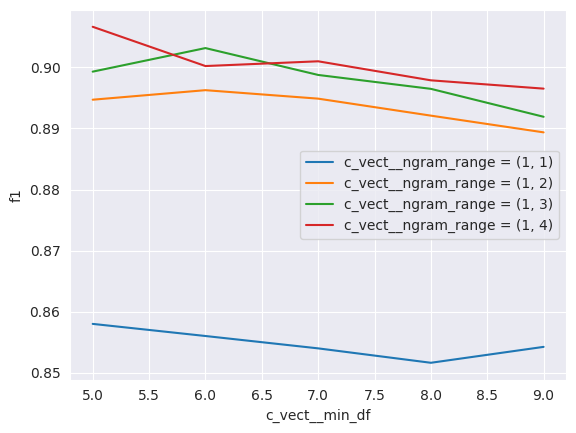

In [57]:
plot_grid_results(grid_search_results, x_var='c_vect__min_df', legend_var='c_vect__ngram_range')

### Score on Test Data

In [58]:
nb_pipe_classifier.set_params(**{'c_vect__min_df': 7, 'c_vect__ngram_range': (1, 4)})
nb_pipe_classifier.fit(df_full_train.stemmed_answer, df_full_train.target)
nb_score = round(f1_score(nb_pipe_classifier.predict(df_test.stemmed_answer), df_test.target), 3)
nb_score

0.911

## 2-Layered Pipeline
 Both Naive Bayes and XGBClassifier show good results. At the same time they use different aspects of data, so maybe it's possible to make them enhance each other.
So I plan to do the following:
1. Vectorize the `answer` column and train Naive Bayes on it
2. Apply Naive Bayes to the rows to predict probability `predict_proba()`.
3. Add this probability as another numerical feature to the data_frame
4. Combine this probability with `selected_features` and train XGBoostClassifier on the new set of numerical features

In [59]:
X_train = df_full_train[['stemmed_answer'] + all_features]
y_train = df_full_train.target
X_test = df_test[['stemmed_answer'] + all_features]
y_test = df_test.target

In order to do this trick, I need a custom transformer that wraps the Naive Bayes classifier and uses `predict_proba` in the `transform` method

In [60]:
class ComplementNBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.clf = ComplementNB()

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        probas = self.clf.predict_proba(X)
        return pd.DataFrame(np.array([x[1] for x in probas]), columns=['nb_probability'])

Now I'm creating the pipeline that implements the plan:

In [61]:
nb_pipe = Pipeline([('c_vect', CountVectorizer(min_df=7, ngram_range=(1, 4))),
                     ('nb_proba', ComplementNBTransformer())])

columns = [('nb_pipe', nb_pipe, 'stemmed_answer')]

col_trans = ColumnTransformer(columns, remainder = 'passthrough') # the `remainder` part ensures that `all_features` are passed down the pipeline and later combined with the output of nb_pipe

xgb.set_params(**{'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100})
full_pipe = Pipeline([('nb_col_trans', col_trans),
                     ('clf', rfc)])

cross_val_score(full_pipe, X_train, y_train, scoring='f1').mean()

0.9228020137957966

In [62]:
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('nb_col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nb_pipe',
                                                  Pipeline(steps=[('c_vect',
                                                                   CountVectorizer(min_df=7,
                                                                                   ngram_range=(1,
                                                                                                4))),
                                                                  ('nb_proba',
                                                                   ComplementNBTransformer())]),
                                                  'stemmed_answer')])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=200,
                                        max_features=None, min_samples_leaf=3,
                                        n_estimators=250))])

In [63]:
combined_score = round(f1_score(full_pipe.predict(X_test), y_test), 3)
combined_score

0.935

In [64]:
lr_name = 'Logistic Regression'
xgb_name = 'XGBoost'
rfc_name = 'Random Forest'
nb_name = 'Naive Bayes'
xgb_nb_name = 'XBGBoost + Naive Bayes'
test_scores_df = pd.DataFrame({lr_name: [lr_score],
                   xgb_name: [xgb_score],
                   rfc_name: [rfc_score],
                   nb_name: [nb_score],
                   xgb_nb_name: [combined_score]})

feature_based_name = 'Feature based'
distribution_based_name = 'Distribution based'
combined_name = 'Combined pipeline'

columns = [(feature_based_name, lr_name),
           (feature_based_name, xgb_name),
           (feature_based_name, rfc_name),
           (distribution_based_name, nb_name),
           (combined_name, xgb_nb_name)]

test_scores_df.columns = pd.MultiIndex.from_tuples(columns, names=['Approach', 'Models'])

# Results and conclusions

In [71]:
print(round(test_scores_df, 3).to_markdown())

|    |   ('Feature based', 'Logistic Regression') |   ('Feature based', 'XGBoost') |   ('Feature based', 'Random Forest') |   ('Distribution based', 'Naive Bayes') |   ('Combined pipeline', 'XBGBoost + Naive Bayes') |
|---:|-------------------------------------------:|-------------------------------:|-------------------------------------:|----------------------------------------:|--------------------------------------------------:|
|  0 |                                      0.772 |                          0.829 |                                0.823 |                                   0.911 |                                             0.935 |


The combined approach has shown significant improvements over the separate approaches.